In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"
chunk_dict={"time":100,"lev":40,"lat":50,"lon":50}


In [3]:
m="NICAM"

In [4]:
cli = xr.open_dataset(ap.get_file(m,"cli", region=region+"_3D"), 
                              chunks=chunk_dict).cli[:,:,:284//2,:284//2]
cli

<xarray.DataArray 'cli' (time: 240, lev: 78, lat: 142, lon: 142)>
dask.array<getitem, shape=(240, 78, 142, 142), dtype=float32, chunksize=(100, 40, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-29
  * lon      (lon) float64 143.0 143.1 143.1 143.1 ... 147.9 147.9 148.0 148.0
  * lat      (lat) float64 -4.975 -4.939 -4.904 ... -0.0879 -0.0527 -0.0176
  * lev      (lev) float64 33.15 103.0 180.1 ... 4.376e+04 4.687e+04 5.031e+04
Attributes:
    standard_name:  mass_fraction_of_cloud_ice_in_air
    long_name:      cloud ice mixing ratio
    units:          kg kg-1
    origin:         ms_qi

In [5]:
ntime, nlev, nlat, nlon = cli.shape

In [6]:
iwp = xr.open_dataset(ap.get_file(m,"clivi", 
                                  region=region)).clivi.sel(time=cli.time, 
                                                            method="nearest")[:,:nlat,:nlon]
iwp

<xarray.DataArray 'clivi' (time: 240, lat: 142, lon: 142)>
[4839360 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28T23:45:00
  * lon      (lon) float64 143.0 143.1 143.1 143.1 ... 147.9 147.9 148.0 148.0
  * lat      (lat) float64 -4.975 -4.939 -4.904 ... -0.0879 -0.0527 -0.0176
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_ice
    long_name:      column integrated solid water (ice water path)
    units:          kg m-2
    origin:         sa_cldi

In [9]:
z = cli.lev

In [10]:
m, iwp.shape, cli.shape, z.shape

('NICAM', (240, 142, 142), (240, 78, 142, 142), (78,))

In [13]:
# get IWP percentiles
bin_edges = np.linspace(0,100,26)/100
bin_mid = (bin_edges[:-1]+bin_edges[1:])/2
quantiles = np.quantile(iwp, bin_edges)
iwp_perc = np.zeros(iwp.shape)
for i, mid in enumerate(bin_mid):
    print(i, mid, quantiles[i], quantiles[i+1])
    iwp_perc = np.where(((iwp>=quantiles[i])&(iwp<quantiles[i+1])), mid, iwp_perc)


0 0.02 1.0502912317633673e-08 2.6562261609797144e-06
1 0.06 2.6562261609797144e-06 2.907402558776085e-05
2 0.1 2.907402558776085e-05 0.00012263311364222316
3 0.14 0.00012263311364222316 0.00038707756437361245
4 0.18 0.00038707756437361245 0.0009610342676751316
5 0.22 0.0009610342676751316 0.0019819384068250658
6 0.26 0.0019819384068250658 0.003595172297209502
7 0.30000000000000004 0.003595172297209502 0.005888586379587659
8 0.33999999999999997 0.005888586379587659 0.009026148319244386
9 0.38 0.009026148319244386 0.013191438093781472
10 0.42000000000000004 0.013191438093781472 0.018575799092650412
11 0.45999999999999996 0.018575799092650412 0.02534285992383957
12 0.5 0.02534285992383957 0.03395634606480599
13 0.54 0.03395634606480599 0.04482865005731583
14 0.5800000000000001 0.04482865005731583 0.0586336202919483
15 0.62 0.0586336202919483 0.07625479042530064
16 0.66 0.07625479042530064 0.09904170840978624
17 0.7 0.09904170840978624 0.12904204428195953
18 0.74 0.12904204428195953 0.1685

In [14]:
iwp_perc = xr.DataArray(iwp_perc, dims=iwp.dims, 
                        coords=iwp.coords, attrs={"name":"binned percentiles of iwp"})
                        

In [15]:
cli_binned = cli.groupby_bins(iwp_perc, 25).count()
cli_binned

<xarray.DataArray 'cli' (lev: 78, group_bins: 25)>
dask.array<getitem, shape=(78, 25), dtype=int64, chunksize=(40, 1), chunktype=numpy.ndarray>
Coordinates:
  * group_bins  (group_bins) object (-0.00098, 0.0392] ... (0.941, 0.98]
  * lev         (lev) float64 33.15 103.0 180.1 ... 4.687e+04 5.031e+04

In [10]:
for i,j in cli_binned:
    print("i", i,"\nj", j.values)

ValueError: too many values to unpack (expected 2)

In [14]:
iwp_full = np.repeat(iwp_percentiles[:,np.newaxis,:,:], nlev, axis=1)

In [15]:
z_full = np.repeat(np.repeat(np.repeat(z.values[np.newaxis, :, np.newaxis, np.newaxis], nlon, axis=3), nlat, axis=2), ntime, axis=0)
iwp_full.shape, z_full.shape

((240, 78, 142, 142), (240, 78, 142, 142))

In [16]:
iwp_flat = iwp_full.flatten()

In [20]:
del z, iwp_full

In [22]:
z_flat = z_full.flatten()

In [23]:
del z_full

In [24]:
%whos

Variable          Type           Data/Info
------------------------------------------
ProgressBar       type           <class 'dask.diagnostics.progress.ProgressBar'>
ap                module         <module 'utility.analysis<...>/analysis_parameters.py'>
bin_edges         ndarray        26: 26 elems, type `float64`, 208 bytes
bin_mid           ndarray        25: 25 elems, type `float64`, 200 bytes
chunk_dict        dict           n=4
cli               DataArray      <xarray.DataArray 'cli' (<...>    origin:         ms_qi
cm                module         <module 'matplotlib.cm' f<...>ckages/matplotlib/cm.py'>
colors            dict           n=11
dask              module         <module 'dask' from '/sw/<...>ckages/dask/__init__.py'>
i                 int            24
iwp_flat          ndarray        377470080: 377470080 elems, type `float64`, 3019760640 bytes (2879.8681640625 Mb)
iwp_percentiles   ndarray        240x142x142: 4839360 elems, type `float64`, 38714880 bytes (36.921386718

In [ ]:
cli_flat = cli.values.flatten()

[########################################] | 100% Completed | 42.0s


In [ ]:
del cli

In [25]:
hist, x_edges, y_edges, binnum = stats.binned_statistic_2d(iwp_flat, z_flat, cli_flat, 
                          statistic="count", bins=[np.logspace(-7,2,20),np.linspace(0,20000,12)])

NameError: name 'cli_flat' is not defined

In [17]:
hist.shape

(19, 11)

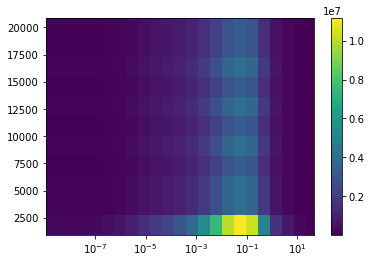

In [18]:
plt.pcolormesh(x_edges[:-1], y_edges[1:], hist.T)
plt.xscale('log')
plt.colorbar()
plt.show()